# NTSC-py

In [1]:
import sys
import ctypes
import cv2
import skimage.io as io
import skimage.transform as T
import numpy as np
from scipy.misc import face
import matplotlib.pyplot as plt
from IPython import display
from moviepy.editor import VideoClip, VideoFileClip
from IPython.display import Video as IPythonVideo
from IPython.display import Image as IPythonImage

In [2]:
from ntsc_py import NES_NTSC
from ntsc_py import NES_PALETTE, rgb2nes, nes2rgb
from ntsc_py import SNES_NTSC
from ntsc_py import SMS_NTSC
from ntsc_py import rgb32_888_to_rgb16_565, rgb16_565_to_rgb32_888

## Video Structures

These structures are used later in the notebook to generate videos from a collection of images, i.e., frames.

In [3]:
class FrameIterator:
    """An iterator for frames of a video."""

    def __init__(self, frames: list) -> None:
        """
        Initialize the iterator for a collection of frames.

        Args:
            frames: the indexable collection of frames

        Returns:
            None

        """
        self._frame_index = 0
        self.frames = frames

    def __call__(self, *args, **kwargs) -> any:
        """Return the current frame and iterate the frame counter."""
        # get the current frame based on the frame counter
        frame = self.frames[self._frame_index]
        # iterate the frame counter if it hasn't 
        # reached the end of the buffer
        if self._frame_index < len(self.frames) - 1:
            self._frame_index += 1
        # return the frame that was indexed by the frame counter
        return frame

## Load Filters

Initialize an object for each of the three filters in the library:

- Nintendo Entertainment System (NES)
- Super Nintendo Entertainment System (SNES)
- Sega Master System (SMS)

In [4]:
nes = NES_NTSC(mode='composite', flicker=True)
(nes.input.dtype, nes.input.shape), (nes.output.dtype, nes.output.shape)

((dtype('uint8'), (240, 256, 1)), (dtype('uint8'), (240, 602, 3)))

In [5]:
snes = SNES_NTSC(mode='composite', flicker=True)
(snes.input.dtype, snes.input.shape), (snes.output.dtype, snes.output.shape)

((dtype('uint16'), (240, 256, 1)), (dtype('uint8'), (240, 602, 3)))

In [6]:
sms = SMS_NTSC(mode='composite')
(sms.input.dtype, sms.input.shape), (sms.output.dtype, sms.output.shape)

((dtype('uint16'), (240, 256, 1)), (dtype('uint8'), (240, 602, 3)))

### Input Buffer (Lossy RGB Encoding)

Each filter accepts a different image data format with a smaller palette than 24-bit RGB. Lossy encode a 24-bit RGB image and decode it to visualize the quantization noise, distortion, etc. The NES has a 6-bit palette, whereas the SNES and SMS both use a more contemporary 16-bit RGB palette. The quantization noise in the NES image is apparent, but not as visible in the SNES / SMS images.

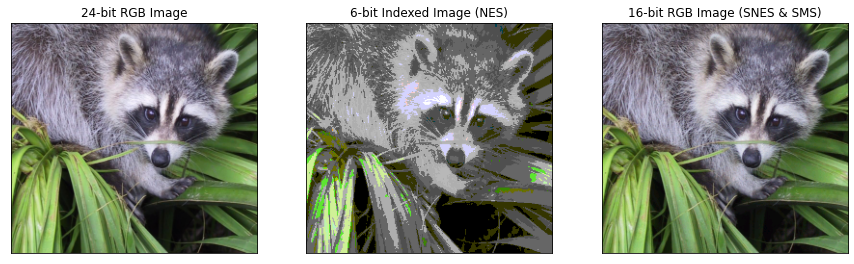

In [7]:
H, W, C = nes.input.shape
# img = T.resize(io.imread('img/python.png'), (H, W), preserve_range=True).round().astype(int)[..., :3]
img = T.resize(face(), (H, W), preserve_range=True).round().astype(int)
plt.figure(figsize=(15, 5))
# 24-bit RGB Image
plt.subplot(1, 3, 1)
ax = plt.imshow(img)
plt.title('24-bit RGB Image')
ax.axes.xaxis.set_major_locator(plt.NullLocator())
ax.axes.yaxis.set_major_locator(plt.NullLocator())
# 6-bit for NES
plt.subplot(1, 3, 2)
ax = plt.imshow(nes2rgb(rgb2nes(img)))
plt.title('6-bit Indexed Image (NES)')
ax.axes.xaxis.set_major_locator(plt.NullLocator())
ax.axes.yaxis.set_major_locator(plt.NullLocator())
# 16-bit for SNES and SMS
plt.subplot(1, 3, 3)
ax = plt.imshow(rgb16_565_to_rgb32_888(rgb32_888_to_rgb16_565(img)))
plt.title('16-bit RGB Image (SNES & SMS)')
ax.axes.xaxis.set_major_locator(plt.NullLocator())
ax.axes.yaxis.set_major_locator(plt.NullLocator())
# save output
plt.savefig('img/color-space.png', bbox_inches='tight')

In [8]:
nes.input[:] = rgb2nes(img)
snes.input[:] = rgb32_888_to_rgb16_565(img)
sms.input[:] = rgb32_888_to_rgb16_565(img)

## Output Buffer

The default state of the output buffer should be empty pixels, i.e., rendered as a black image.

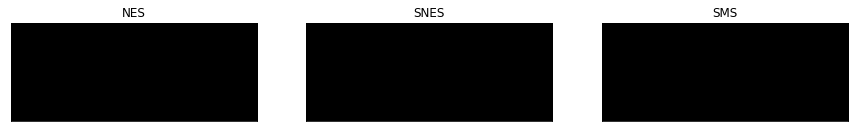

In [9]:
plt.figure(figsize=(15, 5))
# NES
plt.subplot(1, 3, 1)
ax = plt.imshow(nes.output)
plt.title('NES')
ax.axes.xaxis.set_major_locator(plt.NullLocator())
ax.axes.yaxis.set_major_locator(plt.NullLocator())
# SNES
plt.subplot(1, 3, 2)
ax = plt.imshow(snes.output)
plt.title('SNES')
ax.axes.xaxis.set_major_locator(plt.NullLocator())
ax.axes.yaxis.set_major_locator(plt.NullLocator())
# SMS
plt.subplot(1, 3, 3)
ax = plt.imshow(sms.output)
plt.title('SMS')
ax.axes.xaxis.set_major_locator(plt.NullLocator())
ax.axes.yaxis.set_major_locator(plt.NullLocator())

Render a single frame on each filter core.

In [10]:
nes.process()
snes.process()
sms.process()

The output pixels will contain the filtered input image in 24-bit RGB888 format. In memory, it is represented as a 32-bit xRGB8888 data-type.

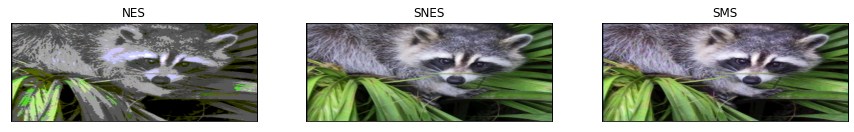

In [11]:
plt.figure(figsize=(15, 5))
# NES
plt.subplot(1, 3, 1)
ax = plt.imshow(nes.output)
plt.title('NES')
ax.axes.xaxis.set_major_locator(plt.NullLocator())
ax.axes.yaxis.set_major_locator(plt.NullLocator())
# SNES
plt.subplot(1, 3, 2)
ax = plt.imshow(snes.output)
plt.title('SNES')
ax.axes.xaxis.set_major_locator(plt.NullLocator())
ax.axes.yaxis.set_major_locator(plt.NullLocator())
# SMS
plt.subplot(1, 3, 3)
ax = plt.imshow(sms.output)
plt.title('SMS')
ax.axes.xaxis.set_major_locator(plt.NullLocator())
ax.axes.yaxis.set_major_locator(plt.NullLocator())

## Process Output

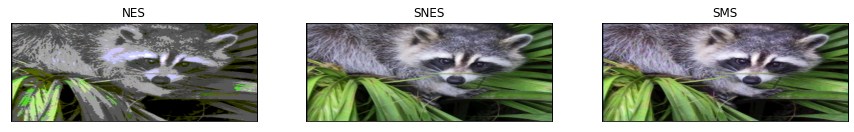

In [12]:
for i in range(60):
    nes.process()
    snes.process()
    sms.process()
    display.clear_output(wait=True)
    plt.figure(figsize=(15, 5))
    # NES
    plt.subplot(1, 3, 1)
    ax = plt.imshow(nes.output)
    plt.title('NES')
    ax.axes.xaxis.set_major_locator(plt.NullLocator())
    ax.axes.yaxis.set_major_locator(plt.NullLocator())
    # SNES
    plt.subplot(1, 3, 2)
    ax = plt.imshow(snes.output)
    plt.title('SNES')
    ax.axes.xaxis.set_major_locator(plt.NullLocator())
    ax.axes.yaxis.set_major_locator(plt.NullLocator())
    # SMS
    plt.subplot(1, 3, 3)
    ax = plt.imshow(sms.output)
    plt.title('SMS')
    ax.axes.xaxis.set_major_locator(plt.NullLocator())
    ax.axes.yaxis.set_major_locator(plt.NullLocator())
    plt.show()

## Watermark inputs

Add a watermark to the inputs to make it obvious which video is which. This will also add some text artifacts due to the filter that are good to visualize.

In [13]:
color = int(rgb2nes([255, 255, 255]).flatten()[0])
_ = cv2.putText(nes.input, 'NES', (35, 90), cv2.FONT_HERSHEY_SIMPLEX, 3, color, 3)
_ = cv2.putText(nes.input, 'NTSC', (10, 190), cv2.FONT_HERSHEY_SIMPLEX, 3, color, 3)

In [14]:
color = int(rgb32_888_to_rgb16_565([255, 255, 255]).flatten()[0])
_ = cv2.putText(snes.input, 'SNES', (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 3, color, 3)
_ = cv2.putText(snes.input, 'NTSC', (10, 190), cv2.FONT_HERSHEY_SIMPLEX, 3, color, 3)

In [15]:
color = int(rgb32_888_to_rgb16_565([255, 255, 255]).flatten()[0])
_ = cv2.putText(sms.input, 'SMS', (35, 90), cv2.FONT_HERSHEY_SIMPLEX, 3, color, 3)
_ = cv2.putText(sms.input, 'NTSC', (10, 190), cv2.FONT_HERSHEY_SIMPLEX, 3, color, 3)

## Adjust Parameters

In [16]:
def generate_frames(path, filt, steps=400, fps=60):
    frames = []
    for i in range(steps):
        filt.setup(
            hue=i/(steps/2) - 1, 
#             saturation=i / (steps/2), 
#             contrast=i / (steps/2) - 1, 
#             brightness=i / (steps/2) - 1, 
#             sharpness=i / (steps/2) - 1, 
#             gamma=i / (steps/2) - 1,
#             artifacts=i / (steps/2),
#             fringing=i / (steps/2),
#             bleed=i / (steps/2),
            saturation=2, 
            artifacts=3,
            fringing=3,
            bleed=10,
        )
        # step the filter
        filt.process()
        shape = list(filt.output.shape)
        shape[1] = shape[1] // 2
        output = T.resize(filt.output, shape, preserve_range=True)
        frames.append(output.round().astype('uint8'))
    # create the video clip using a frame iterator and given FPS
    clip = VideoClip(FrameIterator(frames), duration=(len(frames) / fps))
    clip = clip.set_fps(fps)
    clip.write_videofile(path, logger=None)
    # create a GIF from the frames
    video = VideoFileClip(path)
    video = video.set_fps(1)
    video.write_gif(path.replace('.mp4', '.gif'), logger=None)

    return IPythonImage(filename=path.replace('.mp4', '.gif'), embed=True)

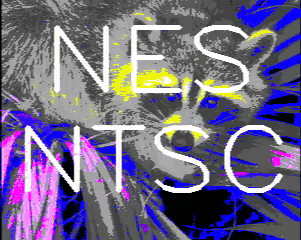

In [17]:
generate_frames('img/nes-ntsc.mp4', nes)

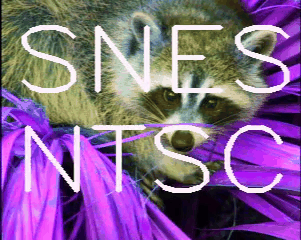

In [18]:
generate_frames('img/snes-ntsc.mp4', snes)

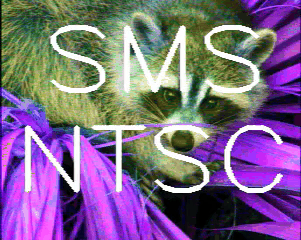

In [19]:
generate_frames('img/sms-ntsc.mp4', sms)